# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [11]:
# Imports

import calendar
from datetime import datetime
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import sys
import xlrd

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

In [15]:
class Neiss:
    DICT_SEX = { 1 : 'Male', 2 : 'Female', 0 : 'Not recorded' }

    DICT_DIAGNOSIS = {
        50 : 'Amputation',
        65 : 'Anoxia',
        42 : 'Aspirated foreign object',
        72 : 'Avulsion',
        48 :  'Burns, scald (from hot liquids or steam)',
        51 : 'Burns, thermal (from flames or hot surface)',
        49 : 'Burns, chemical (caustics, etc.)',
        73 : 'Burns, radiation (includes all cell damage by ultraviolet, x-rays, microwaves, laser beam, radioactive materials, etc.)',
        46 : 'Burns, electrical',
        47 : 'Burns, not specified',
        52 : 'Concussions',
        53 : 'Contusions, Abrasions',
        54 : 'Crushing',
        60 : 'Dental injury',
        74 : 'Dermatitis, Conjunctivitis',
        55 : 'Dislocation',
        67 : 'Electric shock',
        56 : 'Foreign body',
        57 : 'Fracture',
        58 : 'Hematoma',
        66 : 'Hemorrhage',
        41 : 'Ingested foreign object',
        62 : 'Internal organ injury',
        59 : 'Laceration',
        61 : 'Nerve damage',
        68 : 'Poisoning',
        63 : 'Puncture',
        64 : 'Strain or Sprain',
        69 : 'Submersion (including Drowning)',
        71 : 'Other/Not Stated' }

    DICT_BODY_PART = {
        33 : 'Arm, lower (not including elbow or wrist)',
        80 : 'Arm, upper',
        37 : 'Ankle',
        94 : 'Ear',
        32 : 'Elbow',
        77 : 'Eyeball',
        76 : 'Face (including eyelid, eye area and nose)',
        92 : 'Finger',
        83 : 'Foot',
        82 : 'Hand',
        75 : 'Head',
        00  : 'Internal (use with aspiration and ingestion)',
        35 : 'Knee',
        36 : 'Leg, lower (not including knee or ankle)',
        81 : 'Leg, upper',
        88 : 'Mouth (including lips, tongue and teeth)',
        89 : 'Neck',
        38 : 'Pubic region',
        30 : 'Shoulder (including clavicle, collarbone)',
        93 : 'Toe',
        79 : 'Trunk, lower',
        31 : 'Trunk, upper (not including shoulders)',
        34 : 'Wrist',
        84 : '25-50% of body',
        85 : 'All parts of body (more than 50% of body)',
        87 : 'Not recorded' }
    
    DICT_PRODUCT = {
        102 : 'Wringer washing machines',
        106 : 'Electric clothes dryers without washers',
        107 : 'Gas clothes dryers without washers',
        110 : 'Electric heating pads',
        112 : 'Sewing machines or accessories',
        113 : 'Floor buffers or waxers',
        114 : 'Rug shampooers',
        115 : 'Vacuum cleaners',
        116 : 'Electric brooms',
        118 : 'Gas water heaters',
        119 : 'Electric water heaters (excluding immersion heaters)',
        125 : 'Water softeners or conditioners (appliances)',
        127 : 'Clothes dryers, not specified',
        131 : 'Propane, LP or butane gas tanks or fittings',
        132 : 'Electric blankets or sheets',
        133 : 'Other water heaters',
        134 : 'Water heaters, not specified',
        136 : 'Drinking fountains',
        137 : 'Automatic doors or door openers (excluding garage doors)',
        138 : 'Automatic garage doors or door openers',
        139 : 'Incinerators',
        140 : 'Washing machines, other or not specified',
        212 : 'Electric corn poppers',
        213 : 'Electric can openers',
        214 : 'Dishwashers',
        215 : 'Electric blenders',
        216 : 'Electric counter-top ovens, broilers or toaster ovens',
        217 : 'Electric coffee makers or teapots',
        218 : 'Electric or battery-powered knives',
        219 : 'Electric deep fryers',
        221 : 'Food warmers',
        222 : 'Electric frying pans and skillets',
        223 : 'Electric griddles',
        224 : 'Hot plates',
        227 : 'Ice makers (separate from refrigerators)',
        231 : 'Electric mixers',
        232 : 'Electric scissors',
        234 : 'Toasters (excluding toaster ovens)',
        235 : 'Electric waffle irons',
        236 : 'Faucet water heaters',
        237 : 'Garbage disposers',
        240 : 'Electric knife sharpeners',
        241 : 'Rotisseries',
        242 : 'Electric immersion water heaters',
        252 : 'Trash compactors',
        255 : 'Clothes steamers',
        263 : 'Freezers (separate from refrigerators)',
        264 : 'Microwave ovens',
        268 : 'Slow cookers',
        269 : 'Electric kettles or hot pots',
        270 : 'Ice crushers',
        271 : 'Juicers',
        274 : 'Ice cream makers',
        275 : 'Food processors',
        276 : 'Refrigerators',
        277 : 'Clothing irons',
        278 : 'Electric ranges or ovens (excl. counter-top ovens)',
        279 : 'Gas ranges or ovens',
        280 : 'Other ranges or ovens',
        281 : 'Ranges or ovens, not specified',
        304 : 'Humidifiers',
        305 : 'Vaporizers',
        306 : 'Dehumidifiers',
        307 : 'Air purifiers',
        308 : 'Boilers',
        309 : 'Coal furnaces',
        310 : 'Gas furnaces (excluding floor furnaces)',
        311 : 'Oil furnaces (excluding floor furnaces)',
        312 : 'Electric baseboard heaters',
        316 : 'Wood burning fireplaces, factory built',
        318 : 'Electric furnaces (excluding floor furnaces)',
        322 : 'Furnaces, other or not specified',
        334 : 'Gas-burning fireplaces, factory built',
        336 : 'Built-in fireplaces',
        340 : 'Thermostats (for heating or cooling systems)',
        342 : 'Fireplaces, not specified',
        346 : 'Electric fireplaces, factory built',
        348 : 'Portable electric heaters',
        365 : 'Heat pumps',
        367 : 'Coal or wood-burning stoves',
        371 : 'Ductwork for heating or cooling systems (excluding flues)',
        372 : 'Brick, stone or masonry chimneys',
        373 : 'Metal chimneys, stovepipes or flues',
        374 : 'Pipes (excluding smoking pipes)',
        378 : 'Chimneys, not specified',
        379 : 'Radiators (excluding vehicle radiators)',
        380 : 'Fans',
        381 : 'Air conditioners',
        384 : 'Floor furnaces (built into floor)',
        388 : 'Electric heaters, not elsewhere classified',
        390 : 'Heat tapes, electric',
        391 : 'Portable gas or LP heaters',
        392 : 'Gas or LP heaters, other or not specified',
        393 : 'Heaters or heating systems, other or not specified',
        394 : 'Outdoor patio heaters or firepits (manufactured)',
        399 : 'Kerosene or oil heaters',
        401 : 'Nonelectric can openers',
        405 : 'Unpowered coffee makers or teapots',
        408 : 'Ironing boards or covers',
        412 : 'Pressure cookers or canners',
        413 : 'Waste containers, trash baskets or refuse bins',
        416 : 'Corkscrews',
        417 : 'Flatware (excluding knives)',
        419 : 'Tie racks, belt racks or other clothes hangers',
        420 : 'Manual scissors',
        421 : 'Nonelectric knife sharpeners',
        422 : 'Bottle openers',
        427 : 'Ice picks',
        428 : 'Kitchen gadgets, not elsewhere classified',
        429 : 'Food skewers',
        431 : 'Toothpicks or hor d\'oeuvres picks',
        432 : 'Trays (excluding food warmers)',
        434 : 'Doorstops',
        435 : 'Kitchen mixing bowls, canisters or similar containers (excluding plastic products)',
        436 : 'Potholders, oven mitts or hot pads',
        438 : 'Laundry baskets',
        443 : 'Drinking straws',
        444 : 'Knife sharpeners, not specified',
        450 : 'Scissors, not specified',
        452 : 'Coffee makers or teapots, not specified',
        453 : 'Can openers, not specified',
        460 : 'Metal cookware (nonelectric; excluding pressure cookers and canners)',
        461 : 'Nonmetal cookware (nonelectric)',
        462 : 'Chafing dishes or fondue pots',
        463 : 'Candles, candlesticks and other candle holders',
        464 : 'Knives, not elsewhere classified',
        465 : 'Other cookware',
        466 : 'Cookware, not specified',
        469 : 'Slicers and choppers',
        471 : 'Food grinders',
        474 : 'Tableware and accessories (excluding drinking glasses)',
        477 : 'Thermometers (excluding medical thermometers)',
        478 : 'Drinking glasses',
        480 : 'Manual cleaning equipment (excluding buckets or pails)',
        481 : 'Bread making machines',
        482 : 'Appliances, other or not specified',
        519 : 'Television tables or stands',
        529 : 'Telescopes, binoculars, microscopes or magnifying glasses',
        530 : 'Phonograph records',
        531 : 'Recording tapes',
        532 : 'Glass bottle cutting equipment',
        533 : 'Lapidary equipment',
        536 : 'Photographic equipment (excluding chemicals and projectors)',
        545 : 'Amateur two-way radios',
        546 : 'Stereo or hi-fi components or accessories (excluding self-contained units)',
        547 : 'Sound recording, reproducing or receiving equipment, not specified',
        549 : 'Projectors',
        550 : 'Telephones or telephone accessories',
        552 : 'Antennas, not specified',
        555 : 'Radios (self-contained units; excluding two-way radios)',
        556 : 'Tape recorders or players (self-contained units)',
        557 : 'Computers (equipment and electronic games)',
        558 : 'Indoor antennas (separate)',
        559 : 'Radios, not specified',
        561 : 'Outdoor antennas (separate)',
        562 : 'Laser pointers',
        563 : 'Record players (self-contained units)',
        565 : 'Musical instruments, electric or battery operated',
        566 : 'Musical instruments, not electric or not battery operated or not specified',
        567 : 'Coaxial Cable',
        569 : 'Art and ceramic supplies or equipment (excl. paintbrushes)',
        571 : 'Business and office machines',
        572 : 'Televisions',
        573 : 'Other sound recording, reproducing or receiving equipment',
        574 : 'Remote control, universal or not stated (excl. remote controls for toys)',
        575 : 'Compact disks (CDs) and DVDs',
        576 : 'Video players and recorders (excl. cameras)',
        604 : 'Desks, dressers, chests, bureaus, or buffets',
        606 : 'Generators or power plants',
        609 : 'Glass bathtub or shower enclosures',
        610 : 'Nonglass bathtub or shower enclosures',
        611 : 'Bathtubs or showers (including fixtures or accessories; excluding enclosures, faucets, spigots and towel racks)',
        612 : 'Runners, throw rugs or doormats (excluding bathtub mats)',
        613 : 'Room-sized, wall-to-wall or outdoor carpeting (excluding runners)',
        617 : 'Draperies, curtains or shower curtains (fabric or plastic)',
        618 : 'Stepladders (excluding step stools)',
        620 : 'Step stools',
        623 : 'Butane or LP gas meters',
        627 : 'Light bulbs (excluding Christmas tree light bulbs)',
        628 : 'Electric chandeliers, hanging lamps or other attached light fixtures',
        638 : 'Window shades, venetian blinds or indoor shutters',
        639 : 'Flashlights or battery-powered lanterns',
        648 : 'Sinks (excluding faucets)',
        649 : 'Toilets',
        650 : 'Slipcovers',
        651 : 'Table linens',
        652 : 'Pictures, picture frames or wall decorations',
        653 : 'Artificial flowers or plants',
        654 : 'Knickknacks, statues, vases or urns',
        657 : 'Towel racks or bars',
        661 : 'Bunk beds',
        662 : 'Waterbeds or water pillows',
        663 : 'Fireplace equipment',
        666 : 'Towels or cloths',
        667 : 'Bedspreads, throws or comforters',
        669 : 'Clothespins',
        670 : 'Chair, recliner',
        671 : 'Chair, rocking',
        672 : 'Laundry hampers',
        676 : 'Rugs or carpets, not specified',
        679 : 'Sofas, couches, davenports, divans or studio couches',
        680 : 'Convertible beds, hideaway beds or sofa beds',
        685 : 'Extension cords',
        687 : 'Benches (excluding work benches)',
        689 : 'Blankets, not specified',
        692 : 'Magazine racks or book ends',
        693 : 'Footlockers',
        698 : 'Hot tubs or home spas',
        699 : 'Faucets or spigots',
        701 : 'Fire extinguishers',
        702 : 'Fire or smoke alarms',
        704 : 'Burglar alarms',
        706 : 'Lightning rods or arresters, antenna discharge units or other grounding devices',
        707 : 'Padlocks, chain locks or other locks',
        709 : 'Safes',
        710 : 'Electric timers',
        711 : 'Fire escape devices (excluding ladders)',
        712 : 'Carbon monoxide detectors',
        713 : 'Fire sprinklers',
        803 : 'Power sanders',
        804 : 'Power routers',
        805 : 'Power lathes',
        807 : 'Power jointers',
        808 : 'Power shapers',
        809 : 'Other portable or stationary power tools',
        814 : 'Hoists, lifts, jacks or jack stands',
        815 : 'Electrical testing equipment',
        819 : 'Electric motors (separate)',
        820 : 'Internal combustion engines (nonvehicular)',
        821 : 'Automotive tools or accessories',
        823 : 'Air compressors (separate)',
        827 : 'Hammers',
        828 : 'Screwdrivers',
        829 : 'Manual drills',
        830 : 'Hand saws',
        832 : 'Portable circular power saws',
        833 : 'Workshop compounds or chemicals',
        834 : 'Heavy-duty workshop staplers',
        835 : 'Toolboxes or tool kits (excluding tools)',
        836 : 'Knives with replaceable blades',
        837 : 'Wire, not specified',
        841 : 'Bench or table saws',
        842 : 'Band saws',
        843 : 'Radial arm saws',
        845 : 'Saws, not specified',
        847 : 'Drills, not specified',
        852 : 'Rope or string (excluding mountain climbing or jump ropes and kite strings)',
        854 : 'Workshop furnishings',
        855 : 'Portable power drills and accessories',
        856 : 'Stationary power drills and accessories',
        857 : 'Pliers, wire cutters or wrenches',
        858 : 'Reamers',
        859 : 'Soldering equipment, not specified',
        862 : 'Manual filing or sanding tools',
        864 : 'Sabre saws',
        866 : 'Electric soldering equipment',
        868 : 'Nonelectric soldering equipment',
        869 : 'Glue guns',
        870 : 'Awls, chisels or planes',
        871 : 'Power drills or accessories, not specified',
        874 : 'Cutting torches',
        875 : 'Jigsaws',
        877 : 'Trouble lights or extension work lights',
        878 : 'Levels',
        879 : 'Vises or workshop clamps',
        880 : 'Drain snakes',
        881 : 'Other manual workshop tools',
        882 : 'Nail guns or stud drivers',
        883 : 'Battery chargers/adapters',
        884 : 'Batteries',
        885 : 'Chains, not elsewhere classified',
        886 : 'Stretch cords or stretch straps',
        887 : 'Painting equipment, powered (including sprayers, rollers or brushes)',
        888 : 'Sprayers, not elsewhere classified',
        890 : 'Torches, not specified',
        893 : 'Tools, not specified',
        894 : 'Hacksaws',
        895 : 'Power saws, other or not specified',
        896 : 'Welding equipment',
        897 : 'Power workshop grinders, buffers or polishers',
        898 : 'Manual workshop grinders, buffers or polishers',
        899 : 'Workshop grinders, buffers, or polishers, not specified',
        904 : 'Floor waxes',
        905 : 'Furniture polishes or waxes',
        908 : 'Paint or varnish thinners (excluding turpentine)',
        909 : 'Adhesives (excluding tapes)',
        910 : 'Gasoline',
        913 : 'Lubricants',
        914 : 'Dry ice',
        915 : 'Methyl alcohol',
        917 : 'Charcoal',
        920 : 'Caulking or spackling compounds',
        921 : 'Chemicals, not elsewhere classified',
        925 : 'Paintbrushes or rollers, manual',
        926 : 'Photographic chemicals',
        927 : 'Tapes (with adhesive surfaces)',
        929 : 'Drain cleaners',
        930 : 'Ammonia, household',
        931 : 'Metal polishes, tarnish removers or preventatives',
        932 : 'Shoe polishes',
        933 : 'Turpentine',
        934 : 'Dishwasher detergents',
        936 : 'Acids (excluding drain cleaners and battery acids)',
        937 : 'Rust removers',
        938 : 'Swimming pool chemicals',
        940 : 'Lighter fluids',
        941 : 'Fuels for chafing dishes or fondue pots',
        942 : 'Oven cleaners',
        945 : 'Pine oil cleaning and disinfectant preparations',
        949 : 'Laundry soaps or detergents',
        951 : 'Toilet bowl products',
        952 : 'Fabric treatment products (excluding spot removers, cleaning fluids, bleaches and dyes)',
        953 : 'Abrasive cleaners',
        954 : 'General purpose household cleaners (excluding abrasives, ammonia, pine oil and toilet bowl products)',
        955 : 'Automotive chemicals (excluding antifreeze, lubricants, waxes and windshield wiper fluids)',
        956 : 'Bleaches (noncosmetic)',
        957 : 'Dyes (noncosmetic)',
        958 : 'Other polishes',
        959 : 'Polishes, not specified',
        960 : 'Paints, varnishes or shellacs',
        961 : 'Rust preventatives',
        962 : 'Diesel fuels',
        963 : 'Kerosene',
        964 : 'Lamp oils',
        965 : 'Fuel oils, not specified',
        966 : 'Antifreeze',
        967 : 'Windshield wiper fluids',
        968 : 'Caustics (excluding lye)',
        969 : 'Lye',
        970 : 'Wallpaper cleaners (chemical)',
        971 : 'Wallpaper steamers',
        972 : 'Paint or varnish removers, paintbrush cleaners (excluding turpentine)',
        973 : 'Liquid room deodorizers or fresheners',
        974 : 'Solid room deodorizers or fresheners',
        975 : 'Room deodorizers or fresheners, not specified',
        976 : 'Detergents, not specified',
        977 : 'Spot removers or cleaning fluids',
        978 : 'Automotive waxes, polishes or cleaners',
        979 : 'Dishwashing liquid',
        980 : 'Fuel storage tanks (excluding propane, LP and butane tanks)',
        981 : 'Gasoline cans',
        982 : 'School laboratory chemicals',
        983 : 'Soaps (excluding laundry soaps or detergents)',
        984 : 'Solvents, other or not specified',
        1023 : 'Fertilizers, not specified',
        1053 : 'Fertilizers and other chemicals for outdoor use (excluding pesticides)',
        1062 : 'Tractors, other or not specified',
        1102 : 'Vacuum containers',
        1103 : 'Self-contained openers (e.g., zip-top or pull-top cans)',
        1107 : 'Other containers (excluding vacuum or pressurized containers)',
        1112 : 'Metal containers (excluding aerosols, trash and gasoline cans)',
        1114 : 'Cardboard products',
        1116 : 'Containers with key openers',
        1120 : 'Glass soft drink bottles',
        1122 : 'Glass alcoholic beverage bottles',
        1123 : 'Plastic containers (rigid or semi-rigid, excluding bottles and jars)',
        1124 : 'Glass tubing or test tubes',
        1125 : 'Wooden containers',
        1127 : 'Nonglass bottles or jars (excluding baby bottles)',
        1128 : 'Paper bags',
        1130 : 'Plastic bags',
        1131 : 'Plastic wrapping products (excluding plastic bags)',
        1133 : 'Aerosol containers',
        1134 : 'Other glass bottles or jars',
        1135 : 'Bottles or jars, not specified',
        1136 : 'Canning jars',
        1137 : 'Paper products (excluding bags, cups, straws and cardboard products)',
        1138 : 'Pressurized containers (nonaerosol; excluding alcoholic beverage or soft drink bottles and cans)',
        1139 : 'Aluminum foil wrapping products',
        1140 : 'Glass bottles or jars, not specified',
        1141 : 'Containers, not specified',
        1143 : 'Buckets or pails',
        1144 : 'Bags, not elsewhere classified',
        1145 : 'Other specified plastic products',
        1200 : 'Sports and recreational activity, not elsewhere classified',
        1205 : 'Basketball (activity, apparel or equipment)',
        1206 : 'Bowling (activity, apparel or equipment)',
        1207 : 'Boxing (activity, apparel or equipment)',
        1208 : 'Croquet (activity, apparel or equipment)',
        1211 : 'Football (activity, apparel or equipment)',
        1212 : 'Golf (activity, apparel or equipment)',
        1213 : 'Golf carts',
        1215 : 'Lacrosse (activity, apparel or equipment)',
        1217 : 'Sleds',
        1233 : 'Trampolines',
        1234 : 'Treehouses or playhouses',
        1235 : 'Archery (activity, apparel or equipment)',
        1237 : 'Gas, air or spring-operated guns (including BB guns)',
        1239 : 'Horseback riding (activity, apparel or equipment)',
        1240 : 'Aquariums or accessories',
        1242 : 'Slides or sliding boards (excluding swimming pool slides)',
        1243 : 'Seesaws or teeterboards',
        1244 : 'Monkey bars, playground gyms or other playground climbing apparatus',
        1257 : 'Horseshoes (activity, apparel or equipment)',
        1258 : 'Mountain climbing (activity, apparel or equipment)',
        1260 : 'Billiards or pool (activity, apparel or equipment)',
        1261 : 'Surfing (activity, apparel or equipment)',
        1264 : 'Water skiing (activity, apparel or equipment)',
        1266 : 'Volleyball (activity, apparel or equipment)',
        1267 : 'Soccer (activity, apparel or equipment)',
        1269 : 'Table tennis (activity, apparel or equipment)',
        1270 : 'Wrestling (activity, apparel or equipment)',
        1271 : 'Batons',
        1272 : 'Gymnastics (activity, apparel or equipment; excluding trampolines)',
        1273 : 'T oboggans',
        1274 : 'Snow disks',
        1275 : 'Scuba diving (activity, apparel or equipment)',
        1276 : 'Tetherball (activity, apparel or equipment)',
        1277 : 'Swimming pool slides',
        1278 : 'Diving or diving boards',
        1279 : 'Ice hockey (activity, apparel or equipment)',
        1282 : 'Handball (activity, apparel or equipment)',
        1283 : 'Unicycles',
        1284 : 'Swimming pools, not specified',
        1290 : 'Snowmobiles (activity, apparel or equipment)',
        1293 : 'Amusement attractions (including rides)',
        1294 : 'Bleachers',
        1295 : 'Field hockey (activity, apparel or equipment)',
        1299 : 'Snow tubing (activity, apparel or equipment)',
        1301 : 'Tricycles (children\'s)',
        1309 : 'Kites or kite string',
        1310 : 'Pogo sticks',
        1313 : 'Fireworks',
        1314 : 'Rocketry sets',
        1319 : 'Metal or plastic molding sets',
        1322 : 'Children\'s play tents, play tunnels or other enclosures',
        1325 : 'Inflatable toys (excluding balls & balloons)',
        1326 : 'Blocks, stacking toys or pull toys',
        1327 : 'Nonwheeled riding toys, unpowered (e.g., rocking or bouncing horses, etc.)',
        1328 : 'Wagons (children\'s)',
        1329 : 'Scooters, unpowered',
        1330 : 'Powered riding toys',
        1333 : 'Skateboards',
        1338 : 'Toy bows or arrows',
        1342 : 'Costumes or masks',
        1344 : 'Toy musical instruments',
        1345 : 'Building sets',
        1346 : 'Clacker balls',
        1347 : 'Balloons (toy)',
        1349 : 'Stilts',
        1350 : 'Squeeze or squeaker toys',
        1352 : 'Slingshots or sling-propelled toys',
        1353 : 'Toy boxes or chests',
        1354 : 'Marbles',
        1362 : 'Woodburning kits',
        1365 : 'Water toys (excluding squeeze or squeaker toys and inner tubes or similar flotation equipment)',
        1376 : 'Molding compounds',
        1381 : 'Toys, not elsewhere classified',
        1389 : 'Other toy weapons (nonprojectile)',
        1390 : 'Toy guns, not specified',
        1392 : 'Toy sports equipment',
        1393 : 'Chemistry sets or science kits',
        1394 : 'Dolls, plush toys, and action figures',
        1395 : 'Toys, not specified',
        1398 : 'Wheeled riding toys, unpowered (excluding bicycles and tricycles)',
        1399 : 'Toy guns with projectiles',
        1401 : 'Power lawn mowers, not specified',
        1402 : 'Manual push mowers (unpowered)',
        1403 : 'Other unpowered garden tools',
        1405 : 'Garden tractors',
        1406 : 'Snow throwers/blowers',
        1407 : 'Garden sprayers',
        1408 : 'Power tillers or cultivators (not farm equipment)',
        1409 : 'Other power garden tools',
        1411 : 'Chain saws',
        1413 : 'Greenhouse or gardening supplies (excluding plant stands, tools, hoses, sprayers and chemicals)',
        1414 : 'Garden hoses, nozzles or sprinklers',
        1415 : 'Manual snow or ice removal tools',
        1422 : 'Riding power lawn mowers',
        1425 : 'Wheelbarrows or lawn carts',
        1426 : 'Hatchets or axes',
        1427 : 'Power hedge trimmers',
        1430 : 'Seed and fertilizer spreaders',
        1431 : 'Grass and leaf catchers (attachments for lawn mowers)',
        1432 : 'Animal traps',
        1433 : 'Power leaf mulchers and grinders',
        1439 : 'Lawn mowers, not specified',
        1441 : 'Lawn vacuums',
        1445 : 'Plant foods or fertilizers for potted plants',
        1447 : 'Pruning or trimming equipment, not specified',
        1448 : 'Rotary power lawn mowers (walk-behind)',
        1449 : 'Manual hedge trimmers',
        1450 : 'Manual lawn trimmers or edgers',
        1452 : 'Outdoor electric lighting equipment',
        1453 : 'Other manual pruning or trimming equipment',
        1454 : 'Other power pruning or trimming equipment',
        1455 : 'Manual pruning or trimming equipment, not specified',
        1456 : 'Power pruning or trimming equipment, not specified',
        1457 : 'Log splitters',
        1460 : 'Insect traps, powered',
        1461 : 'Leaf blowers',
        1462 : 'Pumps, not elsewhere classified',
        1463 : 'Brushcutters, powered',
        1464 : 'Lawn trimmers or edgers, powered (excluding brushcutters)',
        1465 : 'Decorative yard equipment, excluding water features',
        1466 : 'Decorative water features, including man-made ponds and fountains',
        1502 : 'Baby changing tables',
        1505 : 'Baby carriages',
        1506 : 'Baby gates or barriers',
        1508 : 'Baby walkers or jumpers',
        1509 : 'Baby bottles or nipples',
        1510 : 'Bottle warmers',
        1511 : 'Sterilizers (home use)',
        1512 : 'Diapers',
        1513 : 'Playpens and play yards',
        1515 : 'Baby scales',
        1517 : 'Baby rattles',
        1519 : 'Car seats (for infants or children)',
        1520 : 'Baby exercisers',
        1522 : 'Baby strollers',
        1524 : 'Baby harnesses',
        1525 : 'Pacifiers or teething rings',
        1526 : 'Crib mobiles or crib gyms',
        1527 : 'Baby carriers or slings (backpacks)',
        1528 : 'Diaper pails',
        1529 : 'Portable cribs',
        1531 : 'Baby carriers (bicycle-mounted)',
        1533 : 'Night-lights',
        1535 : 'Potty chairs or training seats (for children)',
        1537 : 'Bassinets or cradles',
        1539 : 'Shoelace fasteners (for infants)',
        1542 : 'Baby mattresses or pads',
        1543 : 'Cribs, nonportable',
        1544 : 'Baby baths or bathinettes',
        1545 : 'Cribs, not specified',
        1548 : 'Baby carriers, not specified',
        1549 : 'Other baby carriers',
        1550 : 'Infant and toddler play centers (excluding jumpers, bouncers, and exercisers',
        1551 : 'Diaper fasteners (excluding safety pins)',
        1553 : 'Portable baby swings (for home use)',
        1554 : 'Safety pins',
        1555 : 'High chairs',
        1556 : 'Attachable high chairs (including booster seats)',
        1557 : 'Baby bathtub seats or rings (not toys)',
        1558 : 'Baby bouncer seats (excl jumpers)',
        1602 : 'Hair dryers',
        1604 : 'Cigarette or pipe lighters',
        1605 : 'Wigs, falls or hairpieces',
        1607 : 'Eye protection devices',
        1610 : 'Massage devices or vibrators (excluding shower attachments)',
        1612 : 'Saunas',
        1613 : 'Electric shoe polishers',
        1615 : 'Footwear',
        1616 : 'Jewelry (excluding watches)',
        1617 : 'Ear protection devices',
        1618 : 'Respiratory protection devices',
        1619 : 'Personal protection devices',
        1622 : 'Watches',
        1623 : 'Luggage (excluding foot lockers)',
        1625 : 'Lighted make-up mirrors',
        1634 : 'Heat or infrared lamps',
        1637 : 'Electric combs',
        1638 : 'Combs or hairbrushes, unpowered',
        1641 : 'Clothes brushes',
        1643 : 'Keys, key rings or key chains',
        1644 : 'Nightwear',
        1645 : 'Day wear',
        1646 : 'Outerwear',
        1647 : 'Clothing accessories',
        1650 : 'Desk supplies (excluding pens and pencils)',
        1651 : 'Combs, not specified',
        1654 : 'Paper cutters',
        1658 : 'Clothing, not specified',
        1659 : 'Manicure, pedicure, and make-up brushes and tools (excluding cosmetics)',
        1660 : 'Umbrellas',
        1661 : 'Nonelectric razors or shavers',
        1662 : 'Hair grooming equipment or accessories, not specified',
        1664 : 'Electric razors or shavers',
        1667 : 'Razors or shavers, not specified',
        1669 : 'Pins and needles (excluding safety pins and knitting needles)',
        1671 : 'Sewing basket articles (excluding scissors, pins, needles and sewing machine accessories)',
        1677 : 'Other clothing',
        1678 : 'Bath or facial cleansing brushes',
        1679 : 'Grocery or shopping carts',
        1680 : 'Dollies, handtrucks or luggage carriers',
        1682 : 'Hair curlers, curling irons, clips & hairpins',
        1683 : 'Hair clippers and trimmers',
        1684 : 'Carts, other or not specified',
        1685 : 'Pens and pencils',
        1686 : 'Coins',
        1687 : 'Lighters, not specified',
        1688 : 'Fuel multi-purpose lighters (incl. micro torches)',
        1689 : 'Electric multi-purpose lighters',
        1690 : 'Multi-purpose lighters, not specified',
        1701 : 'Artificial Christmas trees',
        1711 : 'Christmas tree lights',
        1712 : 'Christmas tree stands or supports',
        1714 : 'Seasonal decorations (excluding Christmas decorations)',
        1715 : 'Pet supplies (excluding foods and medicines)',
        1718 : 'Flares',
        1719 : 'Lunch boxes or pails',
        1720 : 'Party favors',
        1726 : 'Lockers',
        1728 : 'Matchbooks',
        1729 : 'Christmas decorations (nonelectric)',
        1730 : 'Wooden matches',
        1731 : 'Matches, not specified',
        1733 : 'Vending machines (excluding car washing machines)',
        1734 : 'Music boxes or chimes',
        1735 : 'Coin-operated car washing equipment',
        1736 : 'Electric Christmas decorations (excluding Christmas tree lights)',
        1738 : 'Public equipment, not elsewhere classified (including conveyor belts, signs)',
        1739 : 'Ashtrays, electric or battery operated',
        1740 : 'Ashtrays, not electric or not battery operated or not specified',
        1741 : 'Tarpaulins',
        1742 : 'Heating or cooling comfort packs (nonelectric)',
        1744 : 'Motorized vehicles, not elsewhere classified (three or more wheels)',
        1803 : 'Thermal or sound insulation materials',
        1807 : 'Floors or flooring materials',
        1808 : 'Outdoor awnings or shutters',
        1812 : 'Gutters, drainpipes, downspouts or run-off pipes',
        1816 : 'Scaffolding',
        1817 : 'Porches, balconies, open-side floors or floor openings',
        1818 : 'Cisterns, cesspools or septic tanks',
        1819 : 'Nails, screws, carpet tacks or thumbtacks -> Nails, screws, tacks or bolts',
        1820 : 'Cabinet or door hardware',
        1821 : 'Clotheslines or clothes drying racks (excluding poles)',
        1826 : 'Storm windows',
        1828 : 'Window screens',
        1829 : 'Handrails, railings or banisters',
        1840 : 'Pull-down or folding stairs',
        1842 : 'Stairs or steps (excluding pull-down and folding stairs)',
        1843 : 'Ramps or landings',
        1854 : 'Plastic panels for doors or windows',
        1857 : 'Artificial turf',
        1863 : 'W allpaper',
        1864 : 'Counters or countertops (excluding bars)',
        1865 : 'Poles (excluding fence posts, fishing, pole vaults and play-ground equipment)',
        1866 : 'General home or room involvement in fires',
        1870 : 'Windowsills or frames',
        1871 : 'Fences or fence posts',
        1876 : 'House repair or construction materials, not elsewhere classified',
        1878 : 'Doorsills or frames',
        1884 : 'Ceilings and walls (interior part of completed structure)',
        1885 : 'Wood paneling and particleboard',
        1886 : 'Garage doors (excluding automatic garage doors or door openers)',
        1887 : 'Tool sheds',
        1888 : 'Window or door security barriers',
        1889 : 'Elevators or other lifts (excl. escalators, hoists, jacks, forklifts and automotive lifts)',
        1890 : 'Escalators',
        1891 : 'Moving walks',
        1892 : 'Glass doors or doors with glass panels',
        1893 : 'Doors, other or not specified',
        1894 : 'Windows and window glass, other than storm windows',
        1895 : 'Tree stands (hunting)',
        1897 : 'Drywall in a completed structure',
        1898 : 'Gas fumes or gas vapors of unknown origin',
        1899 : 'Carbon monoxide poisonings (when source is unknown)',
        1913 : 'Cosmetics, including facial and eye make-up, deodorants, hair preparations, nail polish and removers, bath oils, skin creams and lotions, etc.',
        1914 : 'Veterinary medicines',
        1915 : 'Liniments or rubbing compounds',
        1916 : 'Preparations containing iron salts',
        1923 : 'Aspirin or aspirin compounds',
        1926 : 'Pesticides',
        1927 : 'Liquid drugs (excluding aspirin, aspirin substitutes, iron preparations and antihistamines)',
        1928 : 'Antihistamines',
        1929 : 'Drugs or medications, not specified',
        1930 : 'Aspirin substitutes',
        1931 : 'Tablet or capsule drugs (excluding aspirin, aspirin substitutes, iron preparations and antihistamines)',
        1932 : 'Other drugs or medications',
        1934 : 'Hot water',
        1935 : 'Gunpowder or ammunition (excluding BBs and pellets)',
        1936 : 'BBs or pellets',
        2300 : 'School equipment',
        2640 : 'Oral hygiene products',
        3200 : 'Water tubing (activity, apparel or equipment)',
        3202 : 'Pedal-powered adult vehicles (three or more wheels)',
        3203 : 'Skeet shooting (activity, apparel or equipment; excluding guns and ammunition)',
        3215 : 'Mopeds or power-assisted cycles',
        3216 : 'Roller skating (activity, apparel or equipment)',
        3217 : 'Skating (activity, apparel or equipment) not specified',
        3218 : 'Charcoal or wood-burning grills',
        3219 : 'Other playground equipment',
        3221 : 'Above-ground swimming pools (excluding portable pools)',
        3222 : 'Badminton (activity, apparel or equipment)',
        3223 : 'Fishing (activity, apparel or equipment; excluding fishing knives)',
        3224 : 'Other guns or firearms',
        3229 : 'Electric grills',
        3230 : 'Kerosene grills or stoves',
        3233 : 'Other grills or stoves',
        3234 : 'Rugby (activity, apparel or equipment)',
        3235 : 'Other ball sports (activity, apparel or equipment)',
        3236 : 'Ball sports (activity, apparel or equipment), not specified',
        3245 : 'Street hockey (activity, apparel or equipment)',
        3246 : 'Swings or swing sets (excluding portable baby swings)',
        3247 : 'Ice or snow boating (activity, apparel or equipment)',
        3248 : 'Gas or LP grills or stoves (for outdoor use)',
        3249 : 'Grills, not specified',
        3250 : 'Portable food or beverage coolers',
        3251 : 'Built-in swimming pools',
        3252 : 'Sleeping bags',
        3253 : 'Guns, not specified',
        3254 : 'Cheerleading (activity, apparel or equipment; excluding batons)',
        3255 : 'Ice skating (activity, apparel or equipment)',
        3256 : 'Squash, racquet ball or paddle ball (activity, apparel or equipment)',
        3257 : 'Martial arts (activity, apparel or equipment)',
        3259 : 'Go-carts',
        3260 : 'Fencing (activity, apparel or equipment)',
        3261 : 'Shuffleboard (activity, apparel or equipment)',
        3262 : 'Swimming pool equipment (excluding chemicals, diving boards and swimming pool slides)',
        3265 : 'Weight lifting (activity, apparel or equipment)',
        3272 : 'Hockey (activity, apparel or equipment), not specified',
        3273 : 'Playground equipment, not specified',
        3274 : 'Swimming (activity, apparel or equipment; excluding flotation devices)',
        3276 : 'Water polo (activity, apparel or equipment)',
        3277 : 'Exercise equipment (excluding weight lifting or gymnastic equipment)',
        3278 : 'Dancing (activity, apparel or equipment)',
        3279 : 'Flotation toys (excluding official life-saving devices)',
        3282 : 'Curling (activity, apparel or equipment)',
        3283 : 'Snow skiing (activity, apparel or equipment)',
        3284 : 'Tennis (activity, apparel or equipment)',
        3285 : 'All-terrain vehicles (three wheels only; exclusively off-road)',
        3286 : 'All-terrain vehicles (four wheels, excluding dune buggies; exclusively off-road)',
        3287 : 'All-terrain vehicles (number of wheels not specified; excluding dune buggies; exclusively off-road)',
        3288 : 'Dune buggies/beach buggies',
        3289 : 'Darts, for indoor use (activity or equipment)',
        3290 : 'Darts, lawn (activity or equipment)',
        3291 : 'Darts, not specified',
        3293 : 'Water slides, not elsewhere classified',
        3294 : 'Water slides, backyard/home (not swimming pool slides)',
        3295 : 'Water slides, public (stationary amusement rides)',
        3296 : 'All-terrain vehicles (more than four wheels; exclusively off-road)',
        3297 : 'In-line skating (activity, apparel or equipment)',
        3299 : 'Exercise (activity or apparel without equipment), including aerobics, stretching, walking, jogging, running (excluding track and field)',
        4002 : 'Bedding, not specified',
        4004 : 'Mirrors or mirror glass (excluding lighted make-up mirrors)',
        4005 : 'Filters (excluding swimming pool and aquarium filters)',
        4008 : 'Nonelectric blankets',
        4009 : 'Nonbaby mattresses (excluding camp mattresses)',
        4010 : 'Mattresses, not specified',
        4011 : 'Inflatable furniture',
        4013 : 'Other furniture',
        4014 : 'Furniture, not specified',
        4016 : 'Beach chairs or folding chairs',
        4025 : 'Barstools or kitchen stools',
        4030 : 'Bathtub or shower enclosures, not specified',
        4039 : 'Other electric lighting equipment',
        4041 : 'Electric lighting equipment, not specified',
        4042 : 'Lighting equipment, not specified',
        4045 : 'Fabrics (not part of finished item)',
        4047 : 'Books, magazines, albums or scrapbooks',
        4050 : 'Pillows (excluding water pillows)',
        4051 : 'Sheets or pillowcases',
        4054 : 'Other bedding',
        4055 : 'Drapery or curtain rods, hooks or rings',
        4056 : 'Cabinets, racks, room dividers and shelves, not elsewhere classified',
        4057 : 'Tables, not elsewhere classified (excl. baby changing tables, billiard or pool tables and television tables or stands)',
        4058 : 'Bars and bar accessories (excluding gymnastic and weight lifting equipment)',
        4060 : 'Fuel-burning lighting equipment',
        4061 : 'Electrical outlets or receptacles',
        4062 : 'Electrical wire or wiring systems (excluding panelboards, receptacles or interrupters)',
        4063 : 'Panelboards, circuit breakers, ground fault circuit interrupters (GFCIs) or fuses',
        4064 : 'Futons',
        4065 : 'Clocks, electric or battery operated',
        4066 : 'Scales, electric or battery operated (excluding baby scales)',
        4067 : 'Clocks, not electric or not battery operated or not specified',
        4068 : 'Scales, not electric or not battery operated or not specified (excluding baby scales)',
        4069 : 'Cots',
        4070 : 'Floor lamps or table lamps, halogen',
        4071 : 'Floor lamps or table lamps, electric (excluding halogen lamps)',
        4074 : 'Chairs, other or not specified',
        4075 : 'Bed rails',
        4076 : 'Beds or bedframes, other or not specified',
        4077 : 'Extension or straight ladders',
        4078 : 'Ladders, other or not specified',
        4079 : 'Footstools, ottomans or hassocks',
        4080 : 'Stools, other or not specified',
        4081 : 'Cords, electrical, other or not specified',
        4082 : 'Toddler beds',
        4083 : 'Surge suppressors or power strips',
        4084 : 'Residential alternative energy systems for on-site power generation',
        4802 : 'Straps, non-stretch, other, or not specified',
        5001 : 'Other toy weapons (projectile)',
        5005 : 'Riding toys (excluding bicycles and tricycles), not specified',
        5006 : 'Other toy guns',
        5007 : 'Toy weapons, not specified',
        5010 : 'Crayons or chalk (excluding billiard or pool chalk)',
        5011 : 'Book bags or back carriers (excluding baby carriers, luggage and camping equipment)',
        5013 : 'Toy make-up kits or cosmetics (excluding mirrors)',
        5015 : 'Toy caps, cap toys or cap guns',
        5016 : 'Balls, other or not specified',
        5017 : 'Flying discs and boomerangs',
        5018 : 'Doll houses and other play scenes',
        5019 : 'Games or game parts (excluding marbles and computer games)',
        5020 : 'Pretend electronics, tools, housewares, and appliances',
        5021 : 'Toy vehicles (excluding riding toys)',
        5029 : 'Camping equipment (excl. trailers, lighting equipment, sleeping bags, cots, hammocks, coolers, stoves and heaters)',
        5030 : 'Track and field (activity, apparel or equipment; excluding jogging or running for fitness)',
        5031 : 'Snow boarding (activity, apparel or equipment)',
        5032 : 'Roller hockey (activity, apparel or equipment)',
        5033 : 'Mountain or all-terrain bicycles or accessories',
        5034 : 'Softball (activity, apparel or equipment)',
        5035 : 'Minibikes, powered',
        5036 : 'Two-wheeled, powered, off-road vehicles (incl. dirt bikes and trail bikes; excl. mopeds and minibikes)',
        5037 : 'Hammocks',
        5038 : 'Fitness/activity tracker, personal (including pedometers and non-medical heart rate monitors)',
        5040 : 'Bicycles or accessories (excluding mountain or all-terrain bicycles)',
        5041 : 'Baseball (activity, apparel or equipment; excluding softball)',
        5042 : 'Scooters/skateboards, powered',
        5043 : 'Portable swimming pools',
        5044 : 'Utility vehicles',
        5555 : 'Substance ingested or inhaled by a victim under age 5 which could lead to a poisoning and for which there is no current product code.' }

    DICT_RACE = {
        1 : 'White',
        2 : 'Black/African American',
        4 : 'Asian',
        5 : 'American Indian/Alaska Native',
        6 : 'Native Hawaiian/Pacific Islander',
        3 : 'Other',
        0 : 'Not Stated in ED record'}
    
    DICT_LOCALE = {
        1 : 'Home',
        2 : 'Farm/Ranch',
        4 : 'Street or highway',
        5 : 'Other public property',
        6 : 'Manufactured (Mobile) Home',
        7 : 'Industrial Place',
        8 : 'School',
        9 : 'Place of recreation or sports',
        0 : 'Not recorded' }

    DICT_DISPOSITION = {
        1 : 'Treated and released, or examined and released without treatment',
        2 : 'Treated and transferred to another hospital',
        4 : 'Treated and admitted for hospitalization (within same facility)',
        5 : 'Held for observation (includes admitted for observation)',
        6 : 'Left without being seen/Left against medical advice',
        8 : 'Fatality, including DOA, died in ED',
        9 : 'Not recorded' }

    DICT_FIRE_INVOLVEMENT = {
        1 : 'Fire involvement and/or smode inhalation - Fire Dept. attended',
        2 : 'fire involvement and/or smode inhalation - Fire Dept. did not attend',
        3 : 'Fire involvement and/or smode inhalation - Fire Dept. attendance not recorded',
        0 : 'No fire or no flame/smode spread' }


    #DICT_CATEGORY_TRANSLATOR = {
    #                    'Sex'              : DICT_SEX,
    #                    'Diagnosis'        : DICT_DIAGNOSIS,
    #                    'Body_Part'        : DICT_BODY_PART,
    #                    'Product_1'        : DICT_PRODUCT,
    #                    'Product_2'        : DICT_PRODUCT,
    #                    'Race'             : DICT_RACE,
    #                    'Location'         : DICT_LOCALE,
    #                    'Disposition'      : DICT_DISPOSITION,
    #                    'Fire_Involvement' : DICT_FIRE_INVOLVEMENT }

    DICT_CATEGORY_TRANSLATOR = {}

    def __init__(self, df):
        self.df = df
        #self.df['Age'] = self.translateAge(self.df['Age'])

    def setColumnCodeDictionary(column_dictionary):
        Neiss.DICT_CATEGORY_TRANSLATOR = column_dictionary
        
    def getDataFrame(self):
        return self.df

    def getColumnDictionary(column_name):
        return Neiss.DICT_CATEGORY_TRANSLATOR[column_name]

    def extractRowsWhereColumnContainsString(self, column_name, search_values, case=False, translate_codes=False):
        '''
        Search the column specified by column_name for the strings listed in search_values.
        Args:
            column_name (str): The name of the column to search for the strings
            search_values (list): A list containing the strings to search for
            
        Return:
            A dataframe containing the rows where the search was successful
        '''
        # https://kanoki.org/2019/03/27/pandas-select-rows-by-condition-and-string-operations/
        
        
        df = self.df[self.df[column_name].str.contains('|'.join(search_values), case=case)]
        if True == translate_codes:
            df = Neiss.translateCodes(df)
        return df
    
    def extractRowsWhereColumnsContainCode(self, column_names, search_values, translate_codes=False):
        '''
        Search the column specified by column_name for the strings listed in search_values.
        Args:
            column_names (list(str)): Alist containing the names of columns to search for the strings
            search_values (list): A list containing the codes to search for
            
        Return:
            A dataframe containing the rows where the search was successful
        '''
        df = pd.DataFrame()
        for column_name in column_names:
            df_filter = self.df[column_name].isin(search_values)
            if df.empty:
                df = self.df[df_filter]
            else:
                df.append(self.df[df_filter])

        if True == translate_codes:
            df = Neiss.translateCodes(df)
        return df

    def lookupCodeFor(category, lookup_name):
        inverse = {v: k for k, v in Neiss.DICT_CATEGORY_TRANSLATOR[category].items()}
        return inverse[lookup_name]
    
    def translateAge(self, df):
        return [age if age < 200 else (age - 200)/12 for age in df['Age']]

    def translateCodes(df):
        return df.replace( Neiss.DICT_CATEGORY_TRANSLATOR)



## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    df = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET CS677 - Data Science with Python/Project/data/NEISS/neiss_data.pckl  ... done!


In [16]:
def getColumnCodeDictionary(fname):
    d1 = {}
    with xlrd.open_workbook(fname) as workbook:
        sheet_names = workbook.sheet_names()

        for sheet in sheet_names:
            xl_sheet = workbook.sheet_by_name(sheet)

            d2 = {}
            for row_idx in range(0, xl_sheet.nrows):
                code = int(xl_sheet.cell_value(row_idx, 0))
                value = xl_sheet.cell_value(row_idx, 1)
                d2[code] = value
            d1[sheet] = d2
    return d1

column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)


- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [4]:
neiss = Neiss(df)

## Generates a graph showing injuries per year

In [5]:
def showInjuriesPerYear(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number of injuries per year
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_year'] = [t.year for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_year'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Year')

## Generates a graph showing injuries per week (1 ... 52) of the year

In [6]:
def showInjuriesUsingPerWeekOverlay(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number of injuries week within the year
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_week'] = [t.week for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_week'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Week Of The Year')
    ax.set_xticks(range(1,52))


## Generates a graph of aggregated injuries per month

In [7]:
def showInjuriesUsingMonthlyOverlay(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number per month
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_month'] = [t.month for t in df2[date_name]]
    
    
    df3 = pd.pivot_table(
        df2, values='_count', index=['_month'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)
    df3.index = calendar.month_name[1:]

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Month')


## Generates a graph a graph of aggregated injuries per weekday

In [8]:
def showInjuriesUsingWeeklyOverlay(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number per weekday
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_week_day'] = [t.weekday() for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_week_day'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    #df3.index = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
    df3.index = calendar.day_name
    
    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Weekday')


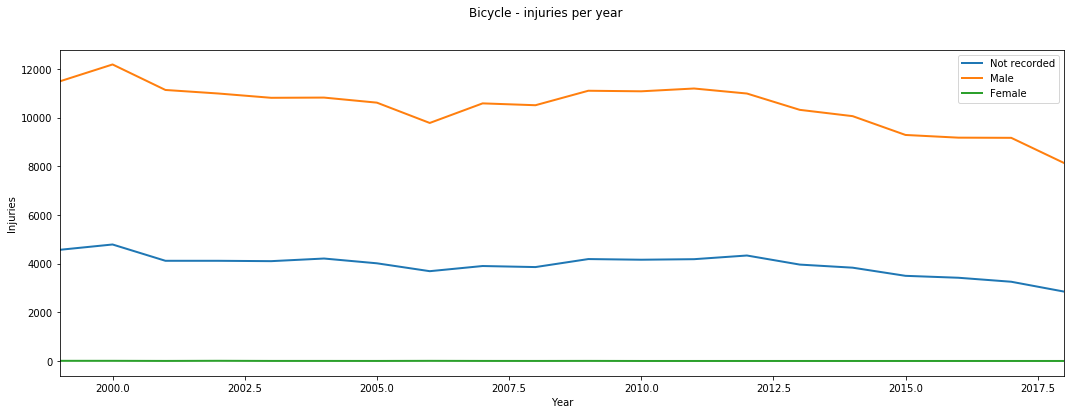

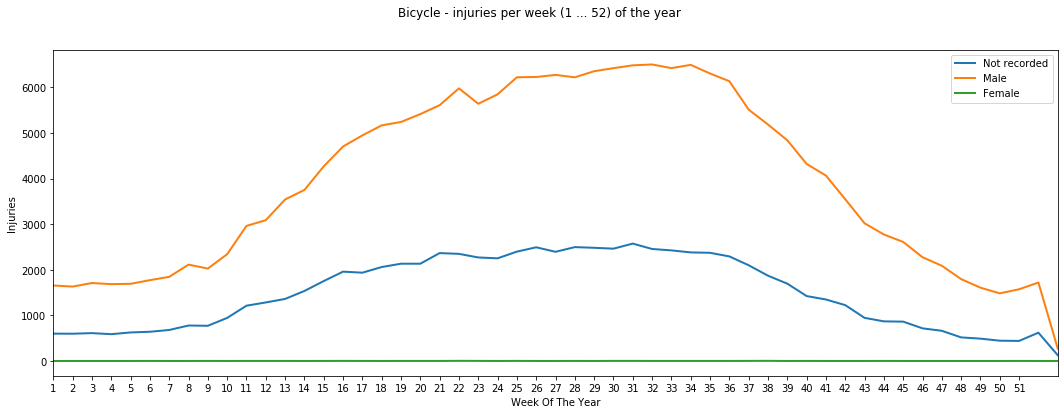

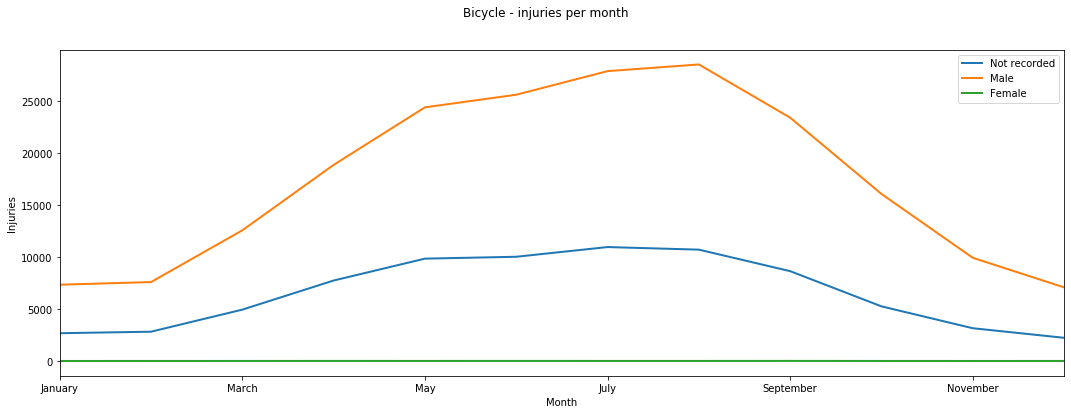

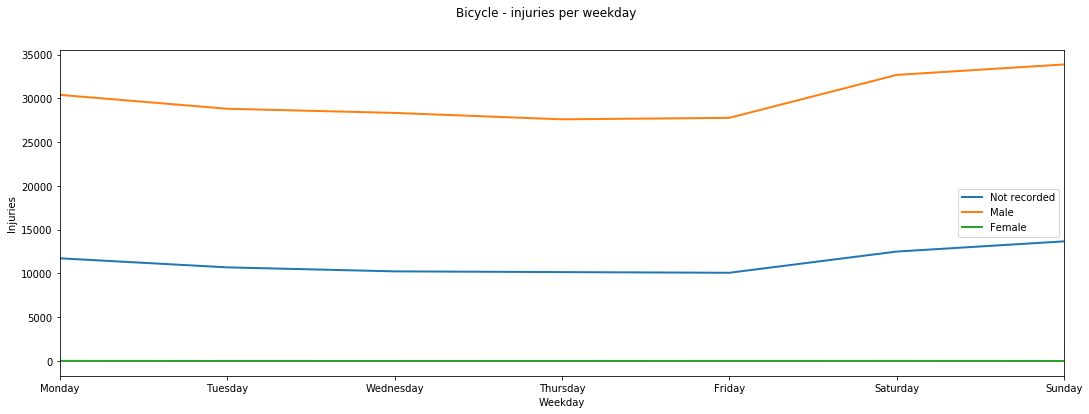

In [9]:

code = Neiss.lookupCodeFor('Product_1', 'Bicycles or accessories (excluding mountain or all-terrain bicycles)')

df = neiss.extractRowsWhereColumnsContainCode(
    column_names = ['Product_1', 'Product_2'],
    search_values = [code],
    translate_codes=True)
df.tail()
neiss = Neiss(df)


showInjuriesPerYear(
    neiss.getDataFrame(),
    date_name = 'Treatment_Date',
    stat_name = 'Sex',
    sup_title = 'Bicycle - injuries per year')

showInjuriesUsingPerWeekOverlay(
    neiss.getDataFrame(),
    date_name = 'Treatment_Date',
    stat_name = 'Sex',
    sup_title = 'Bicycle - injuries per week (1 ... 52) of the year')

showInjuriesUsingMonthlyOverlay(
    neiss.getDataFrame(),
    date_name = 'Treatment_Date',
    stat_name = 'Sex',
    sup_title = 'Bicycle - injuries per month')

showInjuriesUsingWeeklyOverlay(
    neiss.getDataFrame(),
    date_name = 'Treatment_Date',
    stat_name = 'Sex',
    sup_title = 'Bicycle - injuries per weekday')


Basketball Football Tackle Baseball Softball Ball Dance Cricket Hockey Volleyball
Lacrosse Rugby Puck Cycling Bicycle Bike Ski Surfing Soccer Snowboard
Snowmobil Kayak Swim Diving Board Sled Polo Paddle Ballet Toboggan
Trampoline Skating Skate Aerobics Field Oar Run Exercis Tennis Cheerleading
Weightlift Hunting Track Archery Catch Gym Hike Fishing Boxing Bowling
Badminton Hiking Play Racquet Bungee Jog Golf Racket Squash Wrestling
Horseback Martial Fencing Frisbee Sailing Tag
